# Importing the Required Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from xgboost import XGBRegressor
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data

file_path = '../data/processed_data.csv'
data = pd.read_csv(file_path)
print("Columns in CSV:", data.columns.tolist())
print("Shape of data:", data.shape)

Columns in CSV: ['month', 'day', 'country', 'page1_main_category', 'colour', 'location', 'model_photography', 'page', 'avg_price', 'unique_products', 'browsing_depth', 'weekend', 'high_price_preference']
Shape of data: (132379, 13)


In [3]:
# Prepare features and target

val = data.drop('avg_price', axis=1)
tar = data['avg_price']
print("Shape of val before feature selection:", val.shape)

Shape of val before feature selection: (132379, 12)


In [4]:
# Feature selection with XGBRegressor

fs = XGBRegressor(n_estimators=200, random_state=65)
fs.fit(val, tar)
selected = pd.DataFrame({
    "col": val.columns,
    "sco": fs.feature_importances_
}).sort_values("sco", ascending=False)["col"].to_list()
print("Selected features:", selected)
print("Number of selected features:", len(selected))

Selected features: ['high_price_preference', 'page1_main_category', 'browsing_depth', 'unique_products', 'model_photography', 'colour', 'location', 'page', 'country', 'weekend', 'month', 'day']
Number of selected features: 12


In [5]:
val = val[selected]
print("Shape of val after feature selection:", val.shape)

Shape of val after feature selection: (132379, 12)


In [6]:
# Train-test split

x_train, x_test, tr_lab, ts_lab = train_test_split(val, tar, test_size=0.2, random_state=65)
print("Shape of x_train before scaling:", x_train.shape)
print("Shape of x_test before scaling:", x_test.shape)

Shape of x_train before scaling: (105903, 12)
Shape of x_test before scaling: (26476, 12)


In [7]:
# Scale data

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
print("Shape of x_train after scaling:", x_train.shape)
print("Shape of x_test after scaling:", x_test.shape)

Shape of x_train after scaling: (105903, 12)
Shape of x_test after scaling: (26476, 12)


# Linear Regression

In [8]:
# Model building functions

def build_linear_regression(x_train, x_test, tr_lab, ts_lab):
    print('\n----------Building Linear Regression----------')
    lr = LinearRegression()
    lr.fit(x_train, tr_lab)
    ts_pred = lr.predict(x_test)
    rmse = root_mean_squared_error(ts_lab, ts_pred)
    mse = mean_squared_error(ts_lab, ts_pred)
    mae = mean_absolute_error(ts_lab, ts_pred)
    r2 = r2_score(ts_lab, ts_pred)
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    return lr

# Ridge Regression

In [9]:
def build_ridge_regression(x_train, x_test, tr_lab, ts_lab):
    print('\n----------Building Ridge Regression----------')
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        'max_iter': [1000, 2000]
    }
    ridge = Ridge(random_state=65)
    random_search = RandomizedSearchCV(
        ridge, param_grid, n_iter=20, cv=3, scoring='neg_mean_squared_error', n_jobs=1, verbose=1
    )
    random_search.fit(x_train, tr_lab)
    best_model = random_search.best_estimator_
    ts_pred = best_model.predict(x_test)
    rmse = root_mean_squared_error(ts_lab, ts_pred)
    mse = mean_squared_error(ts_lab, ts_pred)
    mae = mean_absolute_error(ts_lab, ts_pred)
    r2 = r2_score(ts_lab, ts_pred)
    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validation Score (neg MSE): {random_search.best_score_:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    return best_model

# Lasso Regression

In [10]:
def build_lasso_regression(x_train, x_test, tr_lab, ts_lab):
    print('\n----------Building Lasso Regression----------')
    param_grid = {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
        'max_iter': [1000, 2000]
    }
    lasso = Lasso(random_state=65)
    random_search = RandomizedSearchCV(
        lasso, param_grid, n_iter=20, cv=3, scoring='neg_mean_squared_error', n_jobs=1, verbose=1
    )
    random_search.fit(x_train, tr_lab)
    best_model = random_search.best_estimator_
    ts_pred = best_model.predict(x_test)
    rmse = root_mean_squared_error(ts_lab, ts_pred)
    mse = mean_squared_error(ts_lab, ts_pred)
    mae = mean_absolute_error(ts_lab, ts_pred)
    r2 = r2_score(ts_lab, ts_pred)
    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validation Score (neg MSE): {random_search.best_score_:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    return best_model

# Gradient Boosting Regression

In [11]:
def build_gradient_boosting_regressor(x_train, x_test, tr_lab, ts_lab):
    print('\n----------Building Gradient Boosting Regression----------')
    print("Shape of x_train in GradientBoosting:", x_train.shape)
    print("Shape of x_test in GradientBoosting:", x_test.shape)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 10],
        'subsample': [0.7, 0.8, 1.0],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    gbr = GradientBoostingRegressor(random_state=65, warm_start=True)
    random_search = RandomizedSearchCV(
        gbr, param_grid, n_iter=20, cv=3, scoring='neg_mean_squared_error', n_jobs=1, verbose=1
    )
    random_search.fit(x_train, tr_lab)
    best_model = random_search.best_estimator_
    ts_pred = best_model.predict(x_test)
    rmse = root_mean_squared_error(ts_lab, ts_pred)
    mse = mean_squared_error(ts_lab, ts_pred)
    mae = mean_absolute_error(ts_lab, ts_pred)
    r2 = r2_score(ts_lab, ts_pred)
    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validation Score (neg MSE): {random_search.best_score_:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    return best_model

# Comparing models

In [12]:
def compare_models(models_dict, x_test, ts_lab):
    print('\n----------Comparing Models---------')
    print("Shape of x_test in compare_models:", x_test.shape)
    results = {}
    for name, model in models_dict.items():
        ts_pred = model.predict(x_test)
        rmse = root_mean_squared_error(ts_lab, ts_pred)
        mse = mean_squared_error(ts_lab, ts_pred)
        mae = mean_absolute_error(ts_lab, ts_pred)
        r2 = r2_score(ts_lab, ts_pred)
        results[name] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'Predictions': ts_pred
        }
    comparison = pd.DataFrame({
        model_name: {
            'MSE': result['MSE'],
            'RMSE': result['RMSE'],
            'MAE': result['MAE'],
            'R2': result['R2']
        }
        for model_name, result in results.items()
    }).T
    comparison = comparison.sort_values('R2', ascending=False)
    print(comparison)
    best_model_name = comparison.index[0]
    best_model = models_dict[best_model_name]
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    sns.barplot(ax=axes[0], x=comparison.index, y='R2', data=comparison, palette='viridis')
    axes[0].set_title('Model R2 Score Comparison')
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('R2 Score')
    axes[0].tick_params(axis='x', rotation=45)
    sns.barplot(ax=axes[1], x=comparison.index, y='RMSE', data=comparison, palette='magma')
    axes[1].set_title('Model RMSE Comparison')
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('RMSE')
    axes[1].tick_params(axis='x', rotation=45)
    plt.show()
    return comparison, results, best_model, best_model_name

# Final Call for all Models


----------Building Linear Regression----------
MSE: 28.6856
RMSE: 5.3559
MAE: 4.0901
R2 Score: 0.2563

----------Building Ridge Regression----------
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_iter': 1000, 'alpha': 10.0}
Best Cross-Validation Score (neg MSE): -28.2905
MSE: 28.6856
RMSE: 5.3559
MAE: 4.0901
R2 Score: 0.2563

----------Building Lasso Regression----------
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_iter': 1000, 'alpha': 0.001}
Best Cross-Validation Score (neg MSE): -28.2904
MSE: 28.6860
RMSE: 5.3559
MAE: 4.0900
R2 Score: 0.2563

----------Building Gradient Boosting Regression----------
Shape of x_train in GradientBoosting: (105903, 12)
Shape of x_test in GradientBoosting: (26476, 12)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10, 'learning_rate': 0.1}
Best Cros

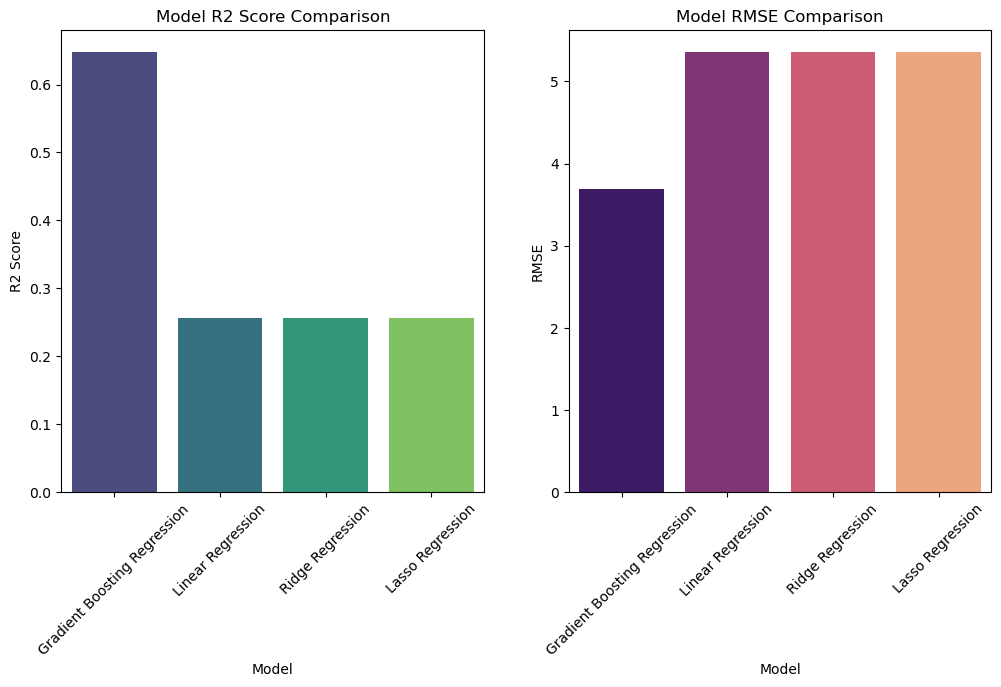


Best Model for Regression: Gradient Boosting Regression saved to 'best_model_reg.pkl'


In [13]:
def run_all_models(x_train, x_test, tr_lab, ts_lab):
    lr = build_linear_regression(x_train, x_test, tr_lab, ts_lab)
    ridge = build_ridge_regression(x_train, x_test, tr_lab, ts_lab)
    lasso = build_lasso_regression(x_train, x_test, tr_lab, ts_lab)
    gbr = build_gradient_boosting_regressor(x_train, x_test, tr_lab, ts_lab)
    models = {
        'Linear Regression': lr,
        'Ridge Regression': ridge,
        'Lasso Regression': lasso,
        'Gradient Boosting Regression': gbr
    }
    comparison, results, best_model, best_model_name = compare_models(models, x_test, ts_lab)
    pickle_path = '..\models'
    os.makedirs(pickle_path, exist_ok=True)
    best_model_reg = os.path.join(pickle_path, 'best_model_reg.pkl')
    with open(best_model_reg, 'wb') as file:
        pickle.dump(best_model, file)
    print(f"\nBest Model for Regression: {best_model_name} saved to 'best_model_reg.pkl'")
    return models, comparison, results, best_model, best_model_name

# Run all models
models, comparison, results, best_model, best_model_name = run_all_models(x_train, x_test, tr_lab, ts_lab) 

In [14]:
# Replace X_new with your actual alternative dataset
X_new = pd.read_csv("..\data\processed_data.csv") 
X_new = X_new[selected]  # Select the same features
X_new_scaled = scaler.transform(X_new)  # Apply the same scaler
prediction = best_model.predict(X_new_scaled)
print("Alternative predictions:", prediction) 

Alternative predictions: [47.04444822 54.77265775 40.89837229 ... 47.89123032 42.69290595
 41.84799024]
